In [1]:
import matplotlib.pyplot as plt
import numpy as np

import optical_gating_analysis as OG
from tqdm import tqdm

from scipy.stats import gaussian_kde

In [2]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif")
oog.sequence_manager.set_reference_sequence(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif")
oog.sequence_manager.reference_period = 73.106274
oog.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif


Getting phases: 100%|██████████| 37970/37970 [00:00<00:00, 181007.60it/s]


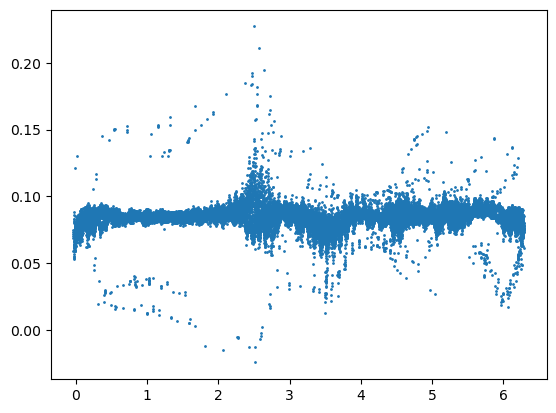

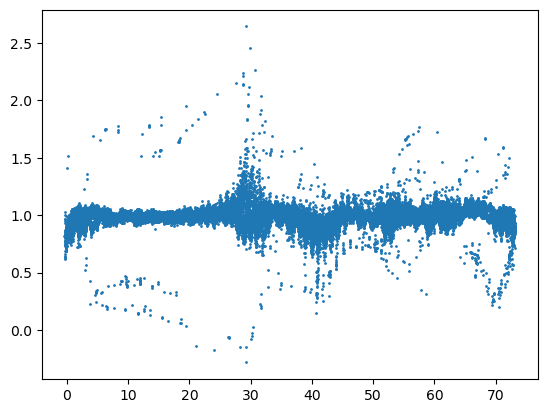

In [3]:
plt.scatter(oog.phases[1::], oog.delta_phases, s = 1)
plt.show()

plt.scatter(oog.phases_frames[1::], oog.delta_phases_frames, s = 1)
plt.show()


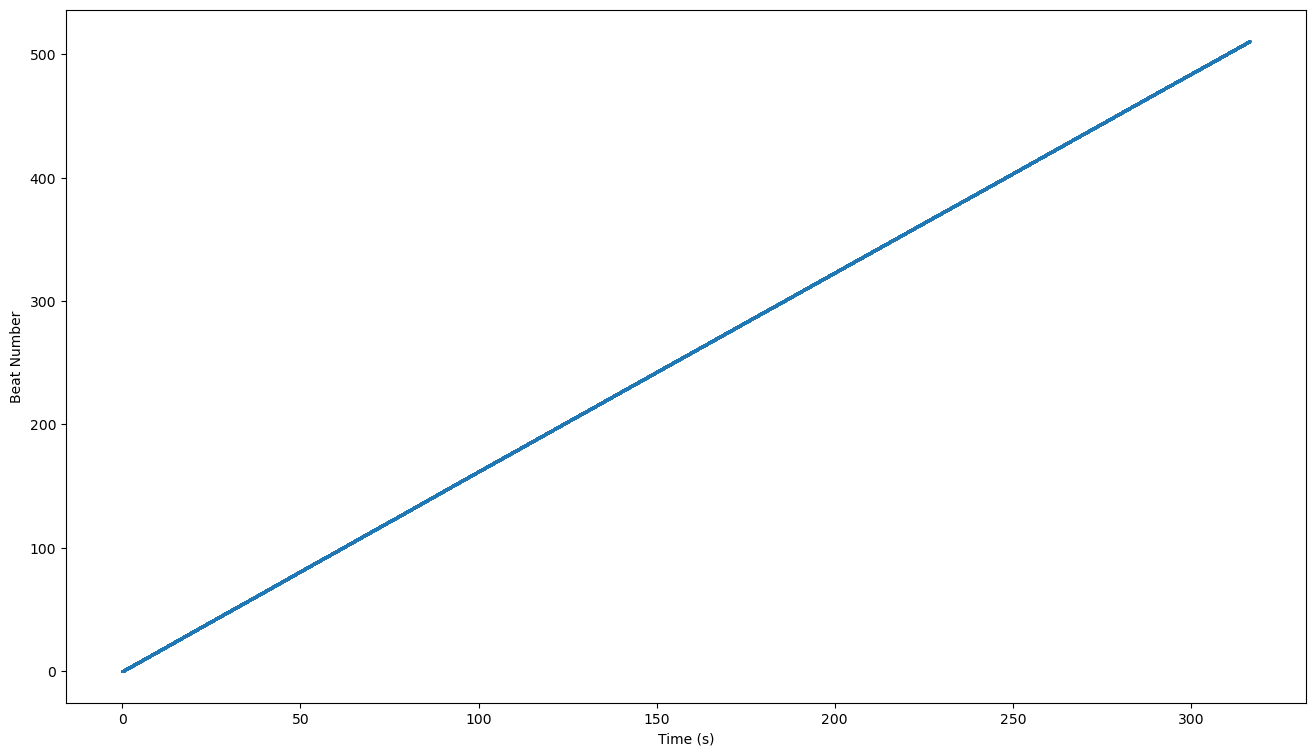

In [4]:
# Plot of beats per second
plt.figure(figsize = (16,9))
plt.scatter(np.arange(oog.unwrapped_phases.shape[0]) / 120, oog.unwrapped_phases / (2 * np.pi), s = 1)
plt.xlabel("Time (s)")
plt.ylabel("Beat Number")
plt.show()

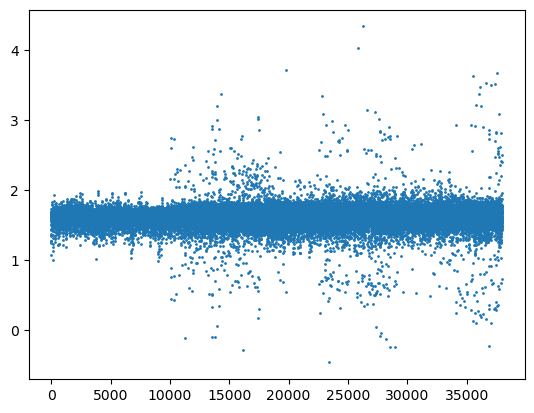

In [5]:
plt.scatter(range(len(oog.delta_phases)), 120 * oog.delta_phases_frames / oog.sequence_manager.reference_period, s = 1)

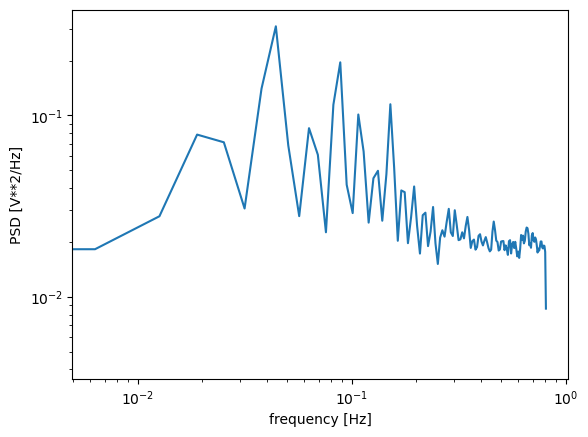

In [6]:
from scipy import signal
fs = np.mean(120 * oog.delta_phases_frames / oog.sequence_manager.reference_period)
f, Pxx_den = signal.welch(120 * oog.delta_phases_frames / oog.sequence_manager.reference_period, fs, nperseg=256)
plt.semilogy(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [13]:
i_prev = 0
beat_indices = []
for i in range(1, oog.phases.shape[0]):
    if (oog.phases[i] - oog.phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > 5:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = (np.arange(oog.delta_phases.shape[0]) / 120)[beat_indices[i]:beat_indices[i+2]]
    ys = (oog.unwrapped_phases / (2 * np.pi))[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

gradients = np.asarray(gradients)

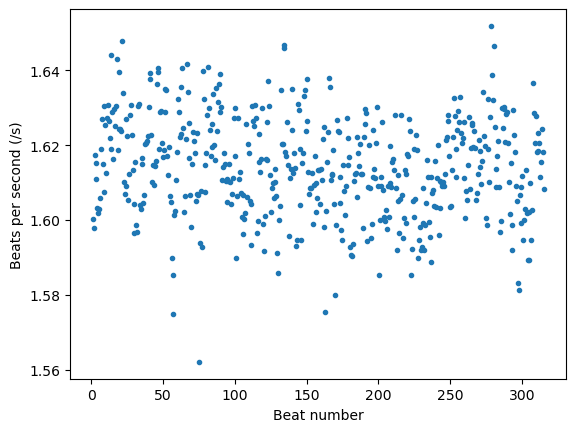

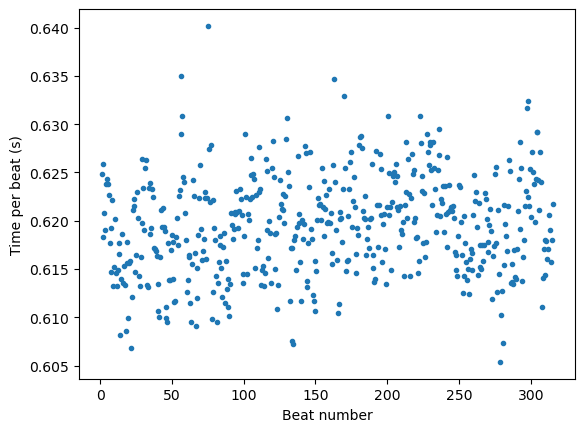

In [18]:
plt.plot(np.array(beat_indices[1:-1]) / 120, gradients, "o", markersize = 3)
plt.ylabel("Beats per second (/s)")
plt.xlabel("Beat number")
plt.show()

plt.plot(np.array(beat_indices[1:-1]) / 120, 1/gradients, "o", markersize = 3)
plt.ylabel("Time per beat (s)")
plt.xlabel("Beat number")
plt.show()

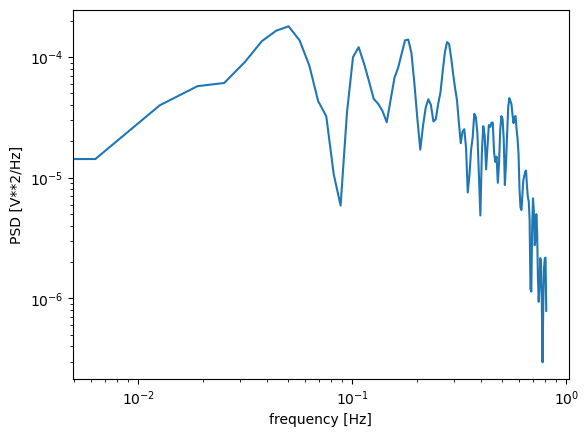

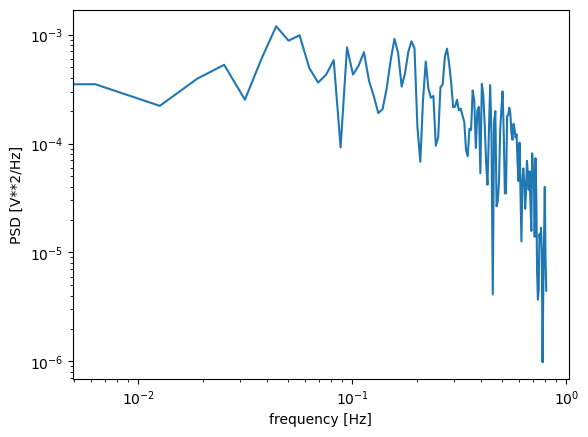

In [55]:
from scipy import signal
fs = np.mean(gradients)
f, Pxx_den = signal.welch(1/gradients, fs, nperseg=256, window = "flattop")
plt.semilogy(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

from scipy import signal
fs = np.mean(gradients)
f, Pxx_den = signal.welch(gradients, fs, nperseg=256)
plt.semilogy(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

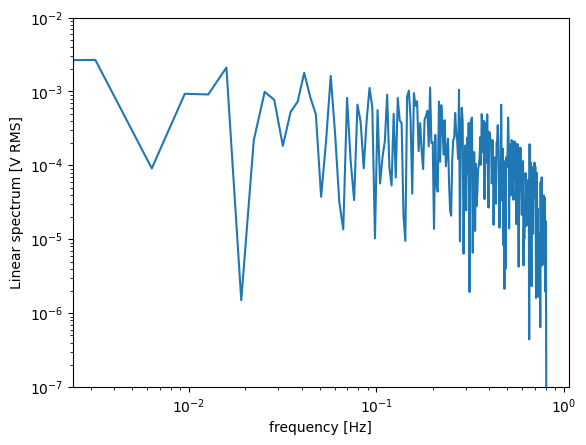

In [36]:
f, Pxx_spec = signal.periodogram(gradients, fs)
plt.figure()
plt.semilogy(f, Pxx_spec)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.ylim(10e-8, 10e-3)
plt.show()

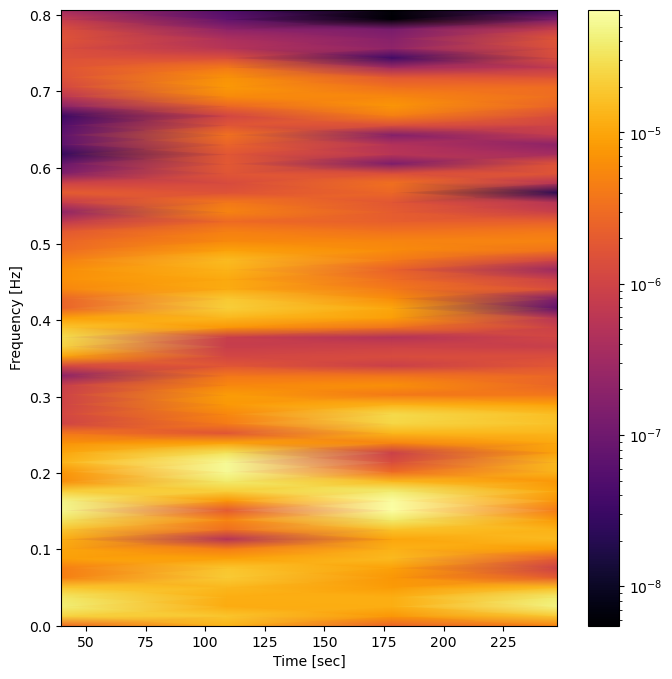

In [51]:
from scipy import signal
f, t, Sxx = signal.spectrogram(np.array(gradients), fs = np.mean(gradients), nperseg = 128, scaling = "spectrum", window = "flattop")
plt.figure(figsize = (8,8))
import matplotlib
plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap = "inferno", norm=matplotlib.colors.LogNorm())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()